In [1]:
import jax.numpy as jnp
from jax import jit,grad,hessian,jacfwd,jacrev,vmap
from jax.config import config
config.update("jax_enable_x64", True)
import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm
plt.style.use("ggplot")

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *
from jax.scipy.linalg import block_diag
from jax.scipy.linalg import solve

from scipy.interpolate import RectBivariateSpline

/home/juanfelipe/anaconda3/envs/jaxenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#u_data = jnp.load("darcy_example_data/u_vals.npy")
x_grid=jnp.linspace(0,1,100)
y_grid=jnp.linspace(0,1,100)
X,Y=jnp.meshgrid(x_grid,y_grid)

@jit
def u_true_function(x1,x2):
    return jnp.exp(jnp.sin(2*(jnp.cos(x1) + jnp.cos(x2))))

def A(x1,x2):
    return jnp.exp(jnp.sin(jnp.cos(x1) + jnp.cos(x2)))
    #return 2.

def A_times_grad_u(x1,x2):
    grad_u = jacfwd(u_true_function, argnums=[0,1])
    return A(x1,x2)*jnp.array(grad_u(x1,x2))

def rhs(x1,x2):
    div = jacfwd(A_times_grad_u, argnums=[0,1])
    return -jnp.trace(jnp.array(div(x1,x2)))

def eval_rhs(pairs):
    return jnp.array(vmap(lambda t: rhs(t[0], t[1]))(pairs))

In [3]:
def build_xy_grid(x_range,y_range,num_grid_x,num_grid_y):
    full_x_grid = jnp.linspace(x_range[0],x_range[1],num_grid_x)
    full_y_grid = jnp.linspace(y_range[0],y_range[1],num_grid_y)


    x_interior = full_x_grid[1:-1]
    y_interior = full_y_grid[1:-1]

    x_boundary = full_x_grid[jnp.array([0,-1])]
    y_boundary = full_y_grid[jnp.array([0,-1])]

    #Get interior points
    x,y = jnp.meshgrid(x_interior,y_interior)
    xy_interior = jnp.vstack([x.flatten(),y.flatten()]).T

    #I'm doing this with meshgrid to handle more general higher dimensions, ie circular domain in 2d
    #Get boundary points
    x,y = jnp.meshgrid(x_interior,y_boundary)
    xy_boundary_1 = jnp.vstack([x.flatten(),y.flatten()]).T

    x,y = jnp.meshgrid(x_boundary,y_interior)
    xy_boundary_2 = jnp.vstack([x.flatten(),y.flatten()]).T

    x,y = jnp.meshgrid(x_boundary,y_boundary)
    xy_boundary_3 = jnp.vstack([x.flatten(),y.flatten()]).T

    xy_boundary = jnp.vstack([xy_boundary_1,xy_boundary_2,xy_boundary_3])
    return xy_interior,xy_boundary

In [4]:
interior,bdy = build_xy_grid([0,1],[0,1],10,10)

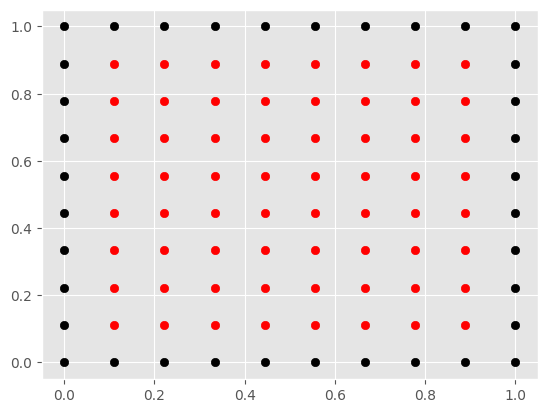

In [5]:
plt.scatter(interior[:,0],interior[:,1],c = 'red')
plt.scatter(bdy[:,0],bdy[:,1],c = 'black')

In [6]:
num_grid_points = 17

xy_int,xy_bdy = build_xy_grid([0,1],[0,1],num_grid_points,num_grid_points)

xy_all = jnp.vstack([xy_bdy,xy_int])

u_true = u_true_function(xy_all[:,0],xy_all[:,1])

num_obs = 10
np.random.seed(20)

x_t_sample_inds = np.random.choice(list(np.arange(len(xy_int))),num_obs,replace = False)
x_t_sample_inds = jnp.hstack([x_t_sample_inds])

xy_obs = jnp.vstack([xy_bdy,xy_int[x_t_sample_inds]])

u_obs = u_true_function(xy_obs[:,0],xy_obs[:,1])

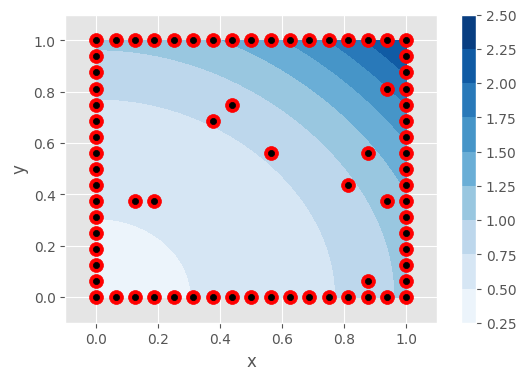

(-0.1, 1.1)

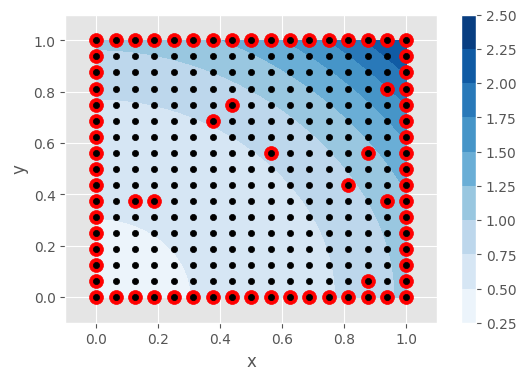

In [7]:
num_fine_grid = 100
x_fine,y_fine = np.meshgrid(np.linspace(0,1,num_fine_grid),np.linspace(0,1,num_fine_grid))
xy_fine = np.vstack([x_fine.flatten(),y_fine.flatten()]).T


plt.figure(figsize=(6,4))

plt.tricontourf(xy_fine[:,0],xy_fine[:,1],u_true_function(xy_fine[:,0],xy_fine[:,1]),cmap = 'Blues')
plt.colorbar()

plt.scatter(xy_obs[:,0],xy_obs[:,1],c='red', s = 100)
plt.scatter(xy_obs[:,0],xy_obs[:,1],c='black',s = 20)


plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.show()

plt.figure(figsize=(6,4))


plt.tricontourf(xy_fine[:,0],xy_fine[:,1],u_true_function(xy_fine[:,0],xy_fine[:,1]),cmap = 'Blues')
plt.colorbar()

plt.scatter(xy_obs[:,0],xy_obs[:,1],c='red', s = 100)
plt.scatter(xy_all[:,0],xy_all[:,1],c='black',s = 20)


plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)

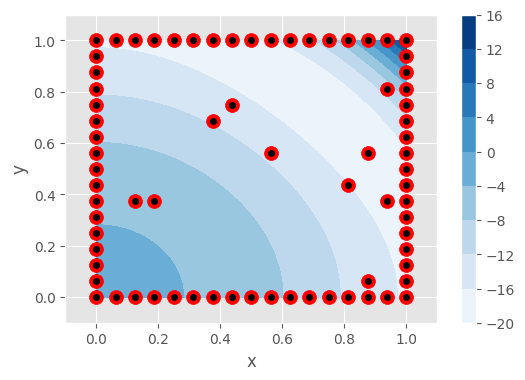

(-0.1, 1.1)

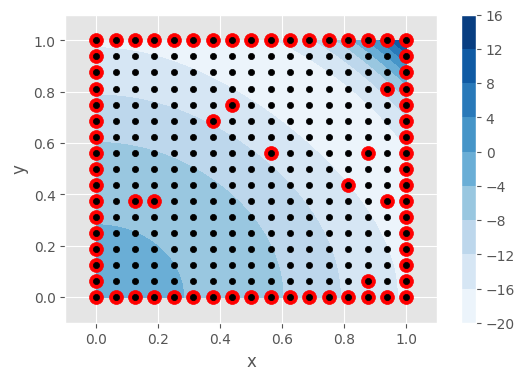

In [8]:
num_fine_grid = 100
x_fine,y_fine = np.meshgrid(np.linspace(0,1,num_fine_grid),np.linspace(0,1,num_fine_grid))
xy_fine = np.vstack([x_fine.flatten(),y_fine.flatten()]).T


plt.figure(figsize=(6,4))

plt.tricontourf(xy_fine[:,0],xy_fine[:,1],eval_rhs(xy_fine),cmap = 'Blues')
plt.colorbar()

plt.scatter(xy_obs[:,0],xy_obs[:,1],c='red', s = 100)
plt.scatter(xy_obs[:,0],xy_obs[:,1],c='black',s = 20)


plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.show()

plt.figure(figsize=(6,4))


plt.tricontourf(xy_fine[:,0],xy_fine[:,1],eval_rhs(xy_fine),cmap = 'Blues')
plt.colorbar()

plt.scatter(xy_obs[:,0],xy_obs[:,1],c='red', s = 100)
plt.scatter(xy_all[:,0],xy_all[:,1],c='black',s = 20)


plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)

In [9]:
type(eval_rhs(xy_int))

jaxlib.xla_extension.ArrayImpl

In [10]:
def diff_x_op(k,index):
    return get_selected_grad(k,index,0)

def diff_xx_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,0)

def diff_y_op(k,index):
    return get_selected_grad(k,index,1)

def diff_yy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,1),index,1)

def diff_xy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,1)

feature_operators = [eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op]


k_u = get_gaussianRBF(0.1)#get_sum_of_kernels([get_gaussianRBF(0.05),get_gaussianRBF(0.2)],coefficients=[0.5,0.5])#get_gaussianRBF(0.1)

u_model = InducedRKHS(
    xy_all,
    feature_operators,
    k_u
    )

u_params_init = u_model.get_fitted_params(xy_obs,u_obs)

grid_features_u_init = (
    (u_model.evaluate_operators(feature_operators,xy_int,u_params_init))
    .reshape(
            len(xy_int),
            len(feature_operators),
            order = 'F'
        )
)

k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_u_init,c=1)
k_P_x_part = get_gaussianRBF(0.1)
def k_P(x,y):
    return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])


class P_model():
    kernel_function = jit(
        get_kernel_block_ops(k_P,[eval_k],[eval_k])
    )

    @jit
    def predict(input_data,params):
        K = P_model.kernel_function(input_data,input_data)
        return K@params

class EqnModel():
    datafit_weight = 10

    @jit
    def get_grid_features(u_params):
        evaluation_u = u_model.evaluate_operators(feature_operators,xy_int,u_params)
        grid_features_u = evaluation_u.reshape(len(xy_int),len(feature_operators),order = 'F')
        full_features = jnp.hstack([xy_int,grid_features_u])
        return full_features
    
    @jit
    def get_grid_target(u_params):
        #return jnp.ones(len(xy_int))
        return eval_rhs(xy_int)
    
    @jit
    def eval_obs_points(u_params):
        return u_model.point_evaluate(xy_obs,u_params)
    
    @jit
    def datafit_residual(u_params):
        obs_preds = EqnModel.eval_obs_points(u_params)
        return u_obs - obs_preds
    
    @jit
    def equation_residual(full_params):
        u_params = full_params[:u_model.num_params]
        P_params = full_params[u_model.num_params:]
        P_features = EqnModel.get_grid_features(u_params)
        P_model_preds = P_model.predict(P_features,P_params)
        ugrid_target = EqnModel.get_grid_target(u_params)
        return (ugrid_target - P_model_preds)
    
    @jit
    def F(full_params):
        u_params = full_params[:u_model.num_params]
        eqn_res = EqnModel.equation_residual(full_params)
        data_res = EqnModel.datafit_residual(u_params)
        return jnp.hstack([
            EqnModel.datafit_weight * data_res/jnp.sqrt(len(data_res)),
            eqn_res/jnp.sqrt(len(eqn_res))
            ])
    
    jac = jit(jacrev(F))

    def loss(full_params):
        return jnp.linalg.norm(EqnModel.F(full_params))**2
    
    @jit
    def damping_matrix(full_params):
        u_params = full_params[:u_model.num_params]
        grid_feats = EqnModel.get_grid_features(u_params)
        kmat_P = P_model.kernel_function(grid_feats,grid_feats)
        dmat = block_diag(
            u_model.kmat+1e-3 * diagpart(u_model.kmat),
            1e-3 * (kmat_P+1e-3 * jnp.identity(len(kmat_P)))
        )
        return dmat

In [11]:
import LM_Solve
import importlib
importlib.reload(LM_Solve)
from LM_Solve import LevenbergMarquadtMinimize
params_init = jnp.hstack([u_params_init,jnp.zeros(len(xy_int))])

params,loss_vals,JtRes,improvement_ratios,alpha_vals,iterate_history = LevenbergMarquadtMinimize(
    params_init.copy(),
    EqnModel,
    beta = 1e-8,
    max_iter = 501,
    init_alpha=1,
    line_search_increase_ratio=3.
)

  1%|          | 3/501 [00:01<02:45,  3.01it/s]

Iteration 0, loss = 0.01065, Jres = 154.8, alpha = 0.9091
Iteration 1, loss = 0.001154, Jres = 174.2, alpha = 0.8264
Iteration 2, loss = 0.0005972, Jres = 62.7, alpha = 0.7513
Iteration 3, loss = 0.0004307, Jres = 7.731, alpha = 0.683
Iteration 4, loss = 0.0003401, Jres = 3.825, alpha = 0.6209
Iteration 5, loss = 0.000285, Jres = 2.287, alpha = 0.5645


 12%|█▏        | 61/501 [00:01<00:06, 71.58it/s]

Iteration 50, loss = 4.568e-05, Jres = 4.921, alpha = 0.007744


 22%|██▏       | 111/501 [00:02<00:04, 93.22it/s]

Iteration 100, loss = 1.631e-05, Jres = 0.1928, alpha = 0.003974


 32%|███▏      | 161/501 [00:02<00:03, 97.30it/s]

Iteration 150, loss = 1.176e-05, Jres = 0.06971, alpha = 0.003974


 40%|████      | 202/501 [00:03<00:05, 58.44it/s]

Iteration 200, loss = 9.438e-06, Jres = 0.01282, alpha = 0.008519
Line Search Failed!
Final Iteration Results
Iteration 202, loss = 9.42e-06, Jres = 0.01054, alpha = 3.594e+07


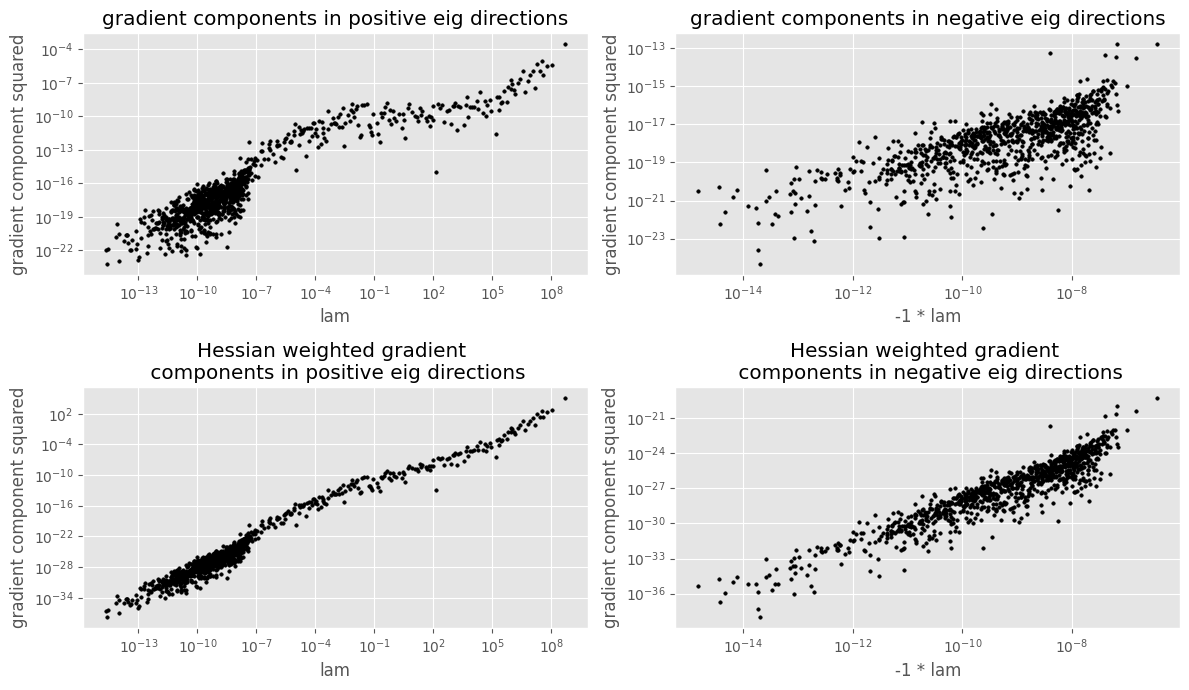

Most negative eigenvalue  -3.5493632191732045e-07


In [12]:
hess_loss = jit(jax.hessian(EqnModel.loss))
gradloss = jit(jax.grad(EqnModel.loss))

H = hess_loss(params)
g = gradloss(params)

analyze_hessian(H,g)

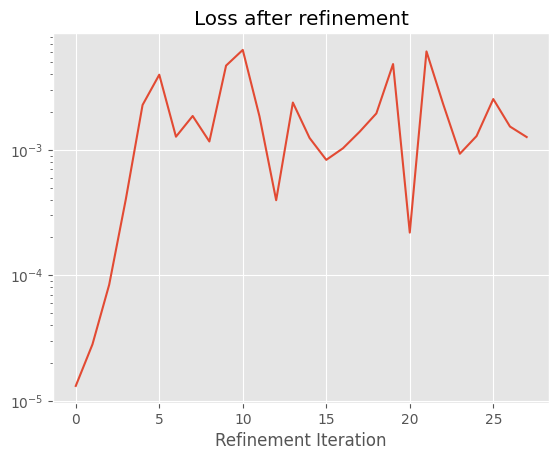

In [13]:
from LM_Solve import refine_solution

p_adjusted,refinement_losses = refine_solution(params,EqnModel)

plt.plot(refinement_losses)
plt.xlabel("Refinement Iteration")
plt.title("Loss after refinement")
plt.yscale('log')

In [ ]:
analyze_hessian(hess_loss(p_adjusted),gradloss(p_adjusted))

In [14]:
u_sol = p_adjusted[:u_model.num_params]
P_sol = p_adjusted[u_model.num_params:]
#params
u_sol = params[:u_model.num_params]
P_sol = params[u_model.num_params:]


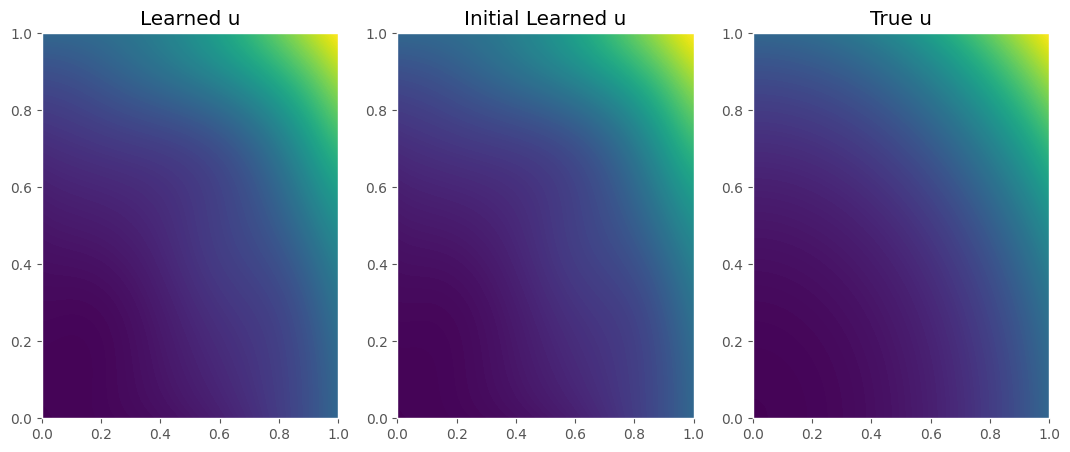

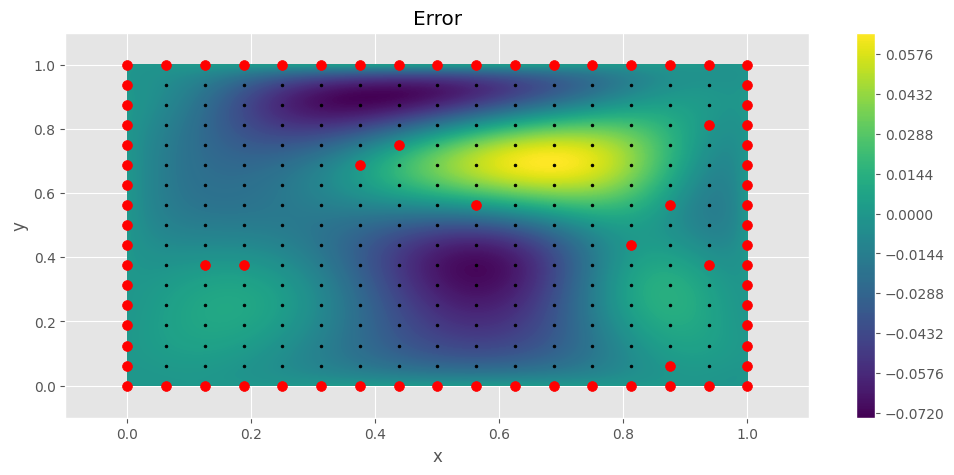

In [15]:
num_fine_grid = 100
x_fine,y_fine = np.meshgrid(np.linspace(0,1,num_fine_grid),np.linspace(0,1,num_fine_grid))
xy_grid_fine = np.vstack([x_fine.flatten(),y_fine.flatten()]).T


u_eval_fine =u_model.point_evaluate(xy_grid_fine,u_sol)
u_eval_fine_init = u_model.point_evaluate(xy_grid_fine,u_params_init)

u_true_fine = u_true_function(xy_grid_fine[:,0],xy_grid_fine[:,1])
plt.figure(figsize=(13,5))
plt.subplot(1,3,1)
plt.title("Learned u")
plt.tricontourf(xy_grid_fine[:,0],xy_grid_fine[:,1],u_eval_fine,200)

plt.subplot(1,3,2)
plt.title("Initial Learned u")
plt.tricontourf(xy_grid_fine[:,0],xy_grid_fine[:,1],u_eval_fine_init,200)

plt.subplot(1,3,3)
plt.title("True u")
plt.tricontourf(xy_grid_fine[:,0],xy_grid_fine[:,1],u_true_fine,200)
plt.show()
plt.figure(figsize = (12,5))
plt.title("Error")
plt.tricontourf(xy_grid_fine[:,0],xy_grid_fine[:,1],u_true_fine-u_eval_fine,250)
plt.colorbar()
plt.scatter(xy_all[:,0],xy_all[:,1],c='black',s = 4)
plt.scatter(xy_obs[:,0],xy_obs[:,1],c='red',s = 50)

plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.show()

In [26]:
num_fine_grid = 50
x_fine,y_fine = np.meshgrid(np.linspace(0.2,0.8,num_fine_grid+4)[2:-2],np.linspace(0.2,0.8,num_fine_grid+4)[2:-2])
xy_fine_int = np.vstack([x_fine.flatten(),y_fine.flatten()]).T

u_true_interior = u_true_function(xy_fine_int[:,0],xy_fine_int[:,1])

model_grid_features = EqnModel.get_grid_features(u_sol)


model_fine_features_u = u_model.evaluate_operators(feature_operators,xy_fine_int,u_sol).reshape(len(xy_fine_int),len(feature_operators),order = 'F')
evaluation_u = u_model.evaluate_operators(feature_operators,xy_fine_int,u_sol)
grid_features_u = evaluation_u.reshape(len(xy_fine_int),len(feature_operators),order = 'F')
model_fine_features = jnp.hstack([xy_fine_int,grid_features_u])


P_preds_model_features = P_model.kernel_function(model_fine_features,model_grid_features)@P_sol

init_P_features = EqnModel.get_grid_features(u_params_init)

K = P_model.kernel_function(init_P_features,init_P_features)

P_params_naive = solve(K+1e-5*diagpart(K),EqnModel.get_grid_target(u_params_init))

init_fine_features_u = u_model.evaluate_operators(feature_operators,xy_fine_int,u_params_init).reshape(len(xy_fine_int),len(feature_operators),order = 'F')
evaluation_u = u_model.evaluate_operators(feature_operators,xy_fine_int,u_sol)
grid_features_u = evaluation_u.reshape(len(xy_fine_int),len(feature_operators),order = 'F')
init_fine_features = jnp.hstack([xy_fine_int,grid_features_u])

P_preds_init_model_features_init = P_model.kernel_function(init_fine_features,init_P_features)@P_params_naive

In [27]:
def get_nrmse(true,pred):
    return jnp.sqrt(jnp.mean((true-pred)**2)/jnp.mean(true**2))

print("Optimized model feature predictions ",get_nrmse(eval_rhs(xy_fine_int),P_preds_model_features))
print("2 Step model feature predictions ",get_nrmse(eval_rhs(xy_fine_int),P_preds_init_model_features_init))

Optimized model feature predictions  3.746803014462074e-05
2 Step model feature predictions  0.00868142480882984


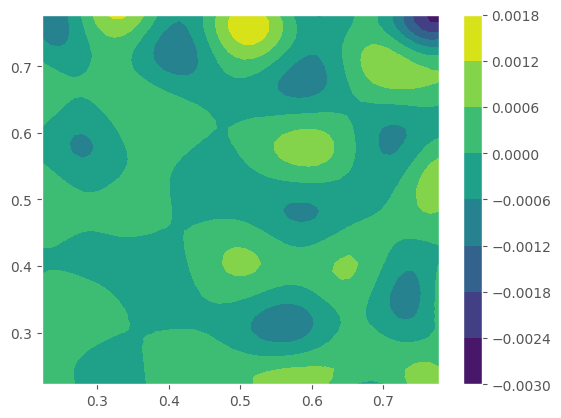

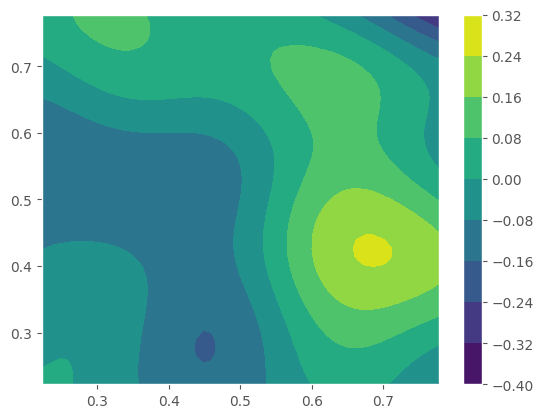

In [28]:
plt.tricontourf(xy_fine_int[:,0],xy_fine_int[:,1],eval_rhs(xy_fine_int)-P_preds_model_features)
plt.colorbar()
plt.show()
plt.tricontourf(xy_fine_int[:,0],xy_fine_int[:,1],eval_rhs(xy_fine_int)-P_preds_init_model_features_init)
plt.colorbar()
plt.show()


In [ ]:
sigma_perm = 0.3
def g_perm(x1,x2):
    return jnp.exp(-((x1 - 0.4)**2 + (x2 - 0.5)**2)/(2*sigma_perm**2))
def permeability_function(x):
    return 1.3 - g_perm(x[0],x[1])

def P(x,y,u):
    def inside(stuff):
        return permeability_function(jnp.array([stuff[0],stuff[1]])) * grad(u)(jnp.array([stuff[0],stuff[1]]))
    return jnp.trace(jacrev(inside)(jnp.array([x,y])))

In [ ]:
def u_example(x):
    return jnp.sin(x[0] + x[1])

def u_example_fake(x,y):
    return jnp.sin(x[0] + x[1])


def Pfunc(x):
    return P(x[0],x[1],u_example)

Pvec = jax.vmap(Pfunc)

truth = Pvec(xy_int)

In [ ]:
@jit
def evaluate_function_features(x):
    return [op(u_example_fake,0)(jnp.array([x[0],x[1]]),jnp.array([0,0])) for op in feature_operators]

vec_eval = jax.vmap(evaluate_function_features)

In [ ]:
test_features_u = jnp.array(vec_eval(xy_int)).T
test_features = jnp.hstack([xy_int,test_features_u])

In [ ]:
get_nrmse(truth,P_model.predict(test_features,P_sol))

In [ ]:
get_nrmse(truth,P_model.predict(test_features,P_params_naive))

In [ ]:
plt.tricontourf(xy_fine[:,0],xy_fine[:,1],permeability_function(xy_fine[:,0],xy_fine[:,1]))
plt.colorbar()